In [2]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [3]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from skbio.stats.composition import clr

from src.config import PROFILE_TYPE, PAIRED_SAMPLES, TARGET, get_experiment_artifacts
from src.visualization.plots import psuedocontrolcomparisonplot, gene_sample_frequency_change_heatmap


In [4]:
psuedo_controls = pd.read_csv(get_experiment_artifacts(profile_type=PAIRED_SAMPLES) + "/psuedo_controls.txt").rename(columns={"0": "Gene"})["Gene"]
psuedo_controls.shape

(100,)

In [5]:
get_experiment_artifacts()

'/Users/colm/repos/MUSICian/notebooks/exploratory/outlier_detection/artifacts/paired-replicates.robust_cov.700/'

In [6]:
outlier_details_df = pd.read_pickle(get_experiment_artifacts(profile_type=PAIRED_SAMPLES) + "/augmented_with_GO_outlier_results.pkl")
outlier_details_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik -0.202316        -0.321429  -0.487511                -0.922377   
0610010K14Rik -0.506267         0.309524  -0.554160                -0.157728   
0610030E20Rik -0.096154         0.130952  -0.334093                 0.255744   
0610040J01Rik  0.585708         0.107143   0.246902                -0.290237   
1110004F10Rik  0.243536        -0.238095   0.024213                -0.282795   
...                 ...              ...        ...                      ...   
Znhit1         0.521094         0.196429   0.292026                 0.799272   
Zranb2         0.953777         0.142857   0.670830                 0.540839   
Zrsr1          0.251496        -0.250000  -0.017179                -1.230343   
Zup1           0.072598        -0.125000  -0.145972                -0.597271   
Zwilch         0.378405         0.071429   0.058281                -0.721362   

Sample                                          T1                         \
Measure       Mean Std Consistency CLR Consistency Consistency  distances   
Gene                                                                        
0610009B22Rik            -1.031957       -0.964286   -0.821429   0.169394   
0610010K14Rik             0.498403        0.392857    0.571429   1.420544   
0610030E20Rik             0.081228        0.178571    0.464286   8.092794   
0610040J01Rik             0.013855        0.000000    0.250000  12.609331   
1110004F10Rik            -0.804186        0.107143   -0.071429   9.343101   
...                            ...             ...         ...        ...   
Znhit1                    0.242960             NaN         NaN        NaN   
Zranb2                    0.106162             NaN         NaN        NaN   
Zrsr1                    -0.801873             NaN         NaN        NaN   
Zup1                     -0.514256             NaN         NaN        NaN   
Zwilch                   -0.055045             NaN         NaN        NaN   

Sample                               T2  ...                        T3  \
Measure         pvalues CLR Consistency  ...   pvalues CLR Consistency   
Gene                                     ...                             
0610009B22Rik  0.999409       -0.142857  ...  0.733467        0.250000   
0610010K14Rik  0.922053       -0.142857  ...  0.731721       -0.214286   
0610030E20Rik  0.151195        0.321429  ...  0.684153        0.071429   
0610040J01Rik  0.027328       -0.392857  ...  0.233254        0.285714   
1110004F10Rik  0.096137       -0.071429  ...  0.283318       -0.142857   
...                 ...             ...  ...       ...             ...   
Znhit1              NaN        0.714286  ...  0.019401        0.107143   
Zranb2              NaN        0.142857  ...  0.033617        0.464286   
Zrsr1               NaN       -0.428571  ...  0.400979       -0.464286   
Zup1                NaN       -0.178571  ...  0.116112       -0.178571   
Zwilch              NaN        0.000000  ...  0.372210       -0.464286   

Sample                                         Gene Sets              \
Measure       Consistency  distances   pvalues   Adamson GeneSubset2   
Gene                                                                   
0610009B22Rik   -0.214286   6.205324  0.286750     False       False   
0610010K14Rik    0.535714   2.871384  0.719807     False       False   
0610030E20Rik   -0.214286   3.765686  0.583620     False       False   
0610040J01Rik    0.142857  14.848909  0.011028     False       False   
1110004F10Rik   -0.428571  11.095744  0.049514     False       False   
...                   ...        ...       ...       ...         ...   
Znhit1          -0.500000   9.115033  0.104563      True       False   
Zranb2           0.464286  18.886149  0.002

In [7]:
X_imputed = pkl.load(open(get_experiment_artifacts(profile_type=PAIRED_SAMPLES) + "/imputed_sample_data.pkl", "rb"))

print("Data Ready.")

Data Ready.


In [8]:
df = pd.concat(X_imputed.values(), keys=X_imputed.keys(), names=["Sample"])
print(df.shape)

outliers_df = df[df.index.get_level_values("Gene").isin(outlier_details_df.index)]
print(outliers_df.shape)

psudo_control_df = df.loc[df.index.get_level_values("Gene").isin(psuedo_controls), :]
psudo_control_gmean_df = pd.DataFrame(psudo_control_df.groupby("Sample").apply(stats.gmean).values.tolist(), index=X_imputed.keys(), columns=df.columns)
psudo_control_gmean_df.index.name="Sample"
psudo_control_gmean_df

psudo_control_gmean_df = psudo_control_gmean_df.div(psudo_control_gmean_df.sum(axis=1), axis=0)

print(psudo_control_gmean_df.shape)

change_df = outliers_df - psudo_control_gmean_df
change_df
print(change_df.shape)

(52400, 7)
(52400, 7)
(3, 7)
(52400, 7)


In [9]:
clr_change_df = {}

for a in X_imputed.keys():
    clrcdf = outliers_df.loc[a, :] .dropna(axis=1)
    clrcdf = pd.DataFrame(clr(clrcdf), index=clrcdf.index, columns=clrcdf.columns)
    clr_change_df[a] = (clrcdf - clr(psudo_control_gmean_df.loc[a, :].dropna()))

clr_change_df = pd.concat(clr_change_df)

### Single Gene Analysis

Polm - Only outlying in target site 2. Therefore, we do not recognise it.


In [10]:
genes = ["Atp6v1g1", "H2ac18", "Metap2", "Qars", "Atp2a2"]
# genes = ["Nabp1", "Baz1b", "Mutyh"]
# genes = ["Cops5", "Dbr1"]

genes = ["Xrcc5", "Xrcc6", "H2ax", "Mad2l2"]
print("Analysing gene:", genes)

Analysing gene: ['Xrcc5', 'Xrcc6', 'H2ax', 'Mad2l2']


In [11]:
ranking_df = outlier_details_df.sort_values(by=("Global", "Mean Score"), ascending=False)
for g in genes:
    print(g)
    print("Ranked: ", ranking_df.index.get_loc(g))

Xrcc5
Ranked:  3
Xrcc6
Ranked:  8
H2ax
Ranked:  4
Mad2l2
Ranked:  6


/Users/colm/repos/MUSICian/src/visualization/plots.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


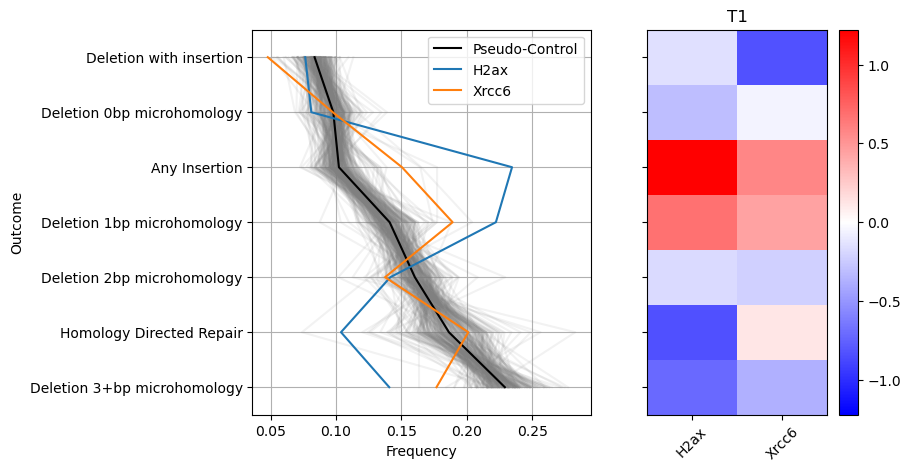

/Users/colm/repos/MUSICian/src/visualization/plots.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


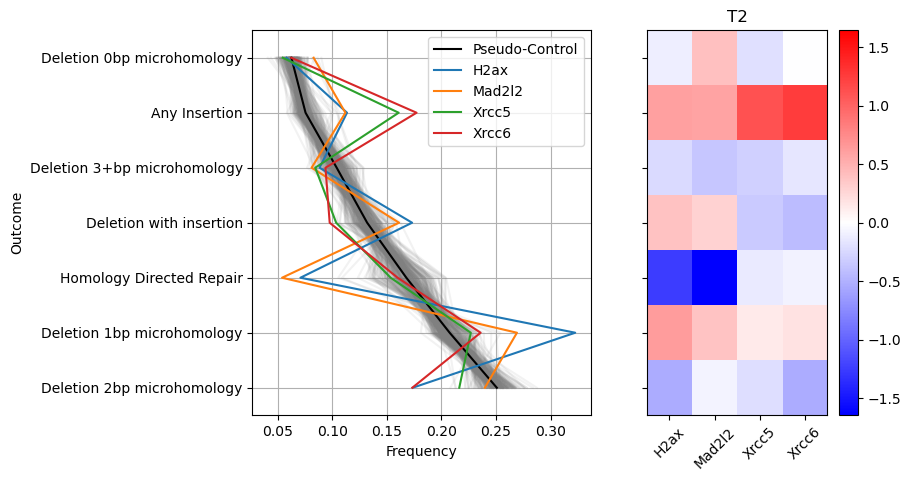

/Users/colm/repos/MUSICian/src/visualization/plots.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)


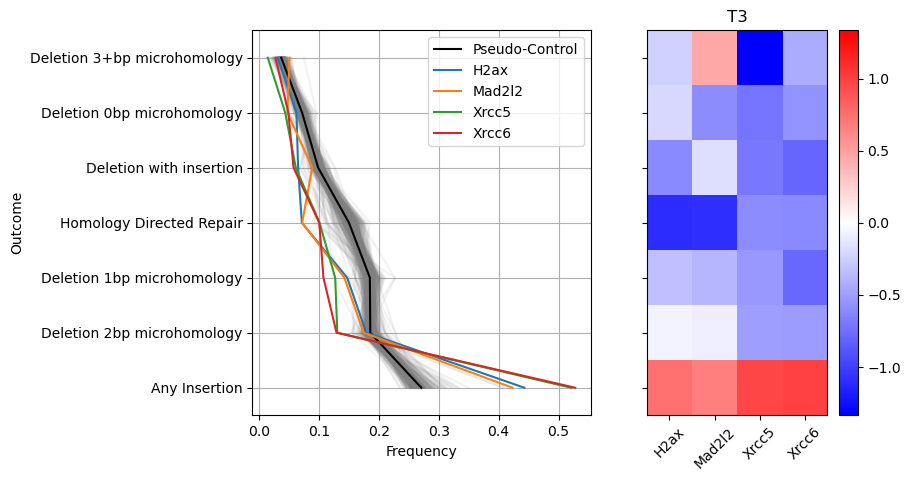

In [12]:
for sample in X_imputed.keys():
    psuedocontrolcomparisonplot(
        df.loc[sample].dropna(axis=1), 
        pseudo_controls=psuedo_controls,
        background_genes = df.loc[sample].dropna(axis=1).index.to_series().sample(300),
        compare_genes = np.intersect1d(df.loc[sample].dropna(axis=1).index.to_list(), 
        genes), num_outcomes=40)
    plt.title(sample)
    plt.show()

In [13]:
if PROFILE_TYPE in [SAMPLE, TARGET]:
    print("Counts:")
    print(outlier_details_df.loc[np.intersect1d(genes, outlier_details_df.index)].xs("Counts", level="Measure", axis=1))
    print("\n")

print("Rejected:")
print(outlier_details_df.loc[np.intersect1d(genes, outlier_details_df.index)].xs("reject", level="Measure", axis=1))
print("\n")

print("P-values:")
print(outlier_details_df.loc[np.intersect1d(genes, outlier_details_df.index)].xs("pvalues", level="Measure", axis=1))
print("\n")

print("Combined using Fisher's method:")
print(stats.combine_pvalues(outlier_details_df.loc[np.intersect1d(genes, outlier_details_df.index)].xs("pvalues", level="Measure", axis=1).replace(0, 1e-10).values.reshape(-1))[1])
print("\n")

print("P-values (FDR corrected):")
print(outlier_details_df.loc[np.intersect1d(genes, outlier_details_df.index)].xs("pvals_corrected", level="Measure", axis=1))
print("\n")

NameError: name 'SAMPLE' is not defined

In [ ]:
outlier_details_df.isna().any(axis=1).sum()

1834

### Similar Gene Search

In [ ]:
df_w_all_targets = df.stack().reset_index().pivot(index="Gene", columns=["Sample", "lumc_category"], values=[0]).droplevel(axis=1, level=0).fillna(0)

for g in genes:
    print("Genes which correlate with ", g)
    print(df_w_all_targets.T.corrwith(df_w_all_targets.loc[g]).sort_values(ascending=False)[1:6])

Genes which correlate with  Polq
Gene
Cdca5       0.989376
Ube2cbp     0.987454
Scd2        0.987336
Timm44      0.987111
Trappc6b    0.987098
dtype: float64
Genes which correlate with  Cdca5
Gene
Bcl2a1d    0.997333
Mrps5      0.996093
Taar7b     0.995864
Ube2cbp    0.995643
Pmf1       0.995311
dtype: float64
